<a href="https://colab.research.google.com/github/rahapal/Swastha-Aalu/blob/anushka/Notebook/SVM_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [3]:
!kaggle datasets download -d muhammadardiputra/potato-leaf-disease-dataset

 79% 20.0M/25.2M [00:00<00:00, 47.9MB/s]
100% 25.2M/25.2M [00:00<00:00, 61.7MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/potato-leaf-disease-dataset.zip','r')
zip_ref.extractall()
zip_ref.close()

In [5]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import tensorflow as tf

from PIL import Image
import cv2

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.svm import SVC

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
TRAINING_DIR = os.path.join('/content/Potato/Train')
VALIDATION_DIR = os.path.join('/content/Potato/Valid')
TESTING_DIR = os.path.join('/content/Potato/Test')
#os.path.join("content",'otherdirectory","train")

In [8]:

IMG_SIZE = (256, 256)

In [9]:
train_images = []
train_labels = []

for directory_path in glob.glob('/content/Potato/Train/*'):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")) + glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [10]:
np.unique(train_labels)

array(['Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy'], dtype='<U21')

In [11]:
val_images = []
val_labels = []

for directory_path in glob.glob('/content/Potato/Valid/*'):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")) + glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        val_images.append(img)
        val_labels.append(label)

val_images = np.array(val_images)
val_labels = np.array(val_labels)

In [12]:
np.unique(val_labels)

array(['Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy'], dtype='<U21')

In [13]:
test_images = []
test_labels = []

for directory_path in glob.glob('/content/Potato/Test/*'):
    label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg"))+ glob.glob(os.path.join(directory_path, "*.JPG")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [14]:
np.unique(test_labels)

array(['Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy'], dtype='<U21')

In [15]:
le = preprocessing.LabelEncoder()

le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

le.fit(val_labels)
val_labels_encoded = le.transform(val_labels)

le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)

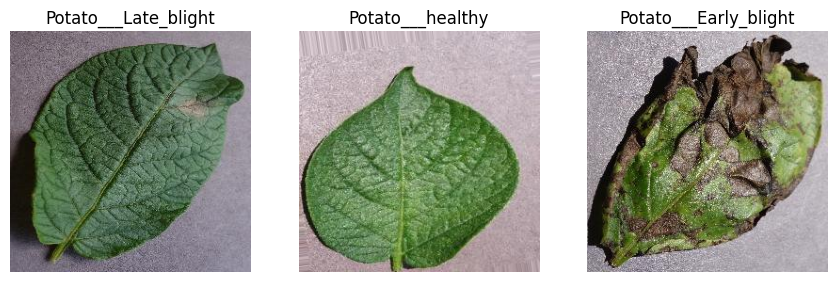

In [16]:
classes = os.listdir('Potato/Train')

plt.figure(figsize=(18,8))

for i, class_ in enumerate(classes):
    pic = os.listdir('Potato/Train/'+ class_)[0]
    image = Image.open('Potato/Train/'+ class_ +'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i+1)
    plt.title(class_)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [17]:
categories = []
train = []
val= []
test = []

folders = os.listdir('Potato/Train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('Potato/Train', f))))

folders = os.listdir('Potato/Valid')
for f in folders:
    val.append(len(os.listdir(os.path.join('Potato/Valid', f))))

folders = os.listdir('Potato/Test')
for f in folders:
    test.append(len(os.listdir(os.path.join('Potato/Test', f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test
                    })

data_count

,categories,train,val,test
0,Potato___Late_blight,300,100,100
1,Potato___healthy,300,100,100
2,Potato___Early_blight,300,100,100


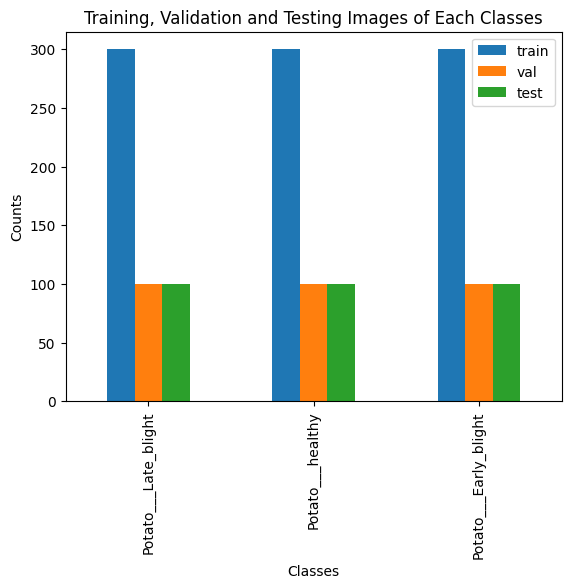

In [18]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [20]:
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [21]:
train_features = base_model.predict(train_images)
train_features = train_features.reshape(train_features.shape[0], -1)
del(train_images)

val_features = base_model.predict(val_images)
val_features = val_features.reshape(val_features.shape[0], -1)
del(val_images)

10/10 [==============================] - 4s 408ms/step


In [22]:
model_1 = SVC(C= 9.0 , kernel='rbf', random_state=42)

model_1.fit(train_features, train_labels_encoded)

train_predictions = model_1.predict(train_features)
train_accuracy = accuracy_score(train_labels_encoded, train_predictions)
print("Training Accuracy:", train_accuracy)

val_predictions = model_1.predict(val_features)
accuracy = accuracy_score(val_labels_encoded, val_predictions)
print("Validation Accuracy:", accuracy)

Training Accuracy: 1.0
Validation Accuracy: 0.99


In [23]:
model_2 = SVC(C = 4.0 ,kernel='poly', random_state=42)

model_2.fit(train_features, train_labels_encoded)

train_predictions = model_2.predict(train_features)
train_accuracy = accuracy_score(train_labels_encoded, train_predictions)
print("Training Accuracy:", train_accuracy)

val_predictions = model_2.predict(val_features)
accuracy = accuracy_score(val_labels_encoded, val_predictions)
print("Validation Accuracy:", accuracy)

Training Accuracy: 0.9988888888888889
Validation Accuracy: 0.97


In [24]:
model_3 = SVC(C = 10.0 ,kernel='sigmoid', random_state=42)

model_3.fit(train_features, train_labels_encoded)

train_predictions = model_3.predict(train_features)
train_accuracy = accuracy_score(train_labels_encoded, train_predictions)
print("Training Accuracy:", train_accuracy)

val_predictions = model_3.predict(val_features)
accuracy = accuracy_score(val_labels_encoded, val_predictions)
print("Validation Accuracy:", accuracy)

Training Accuracy: 1.0
Validation Accuracy: 0.99


In [25]:
del(model_1)
del(model_2)
del(model_3)

In [ ]:
#model = SVC(kernel='rbf', random_state=42)

#model.fit(train_features, train_labels_encoded)

SVC(random_state=42)

In [26]:
model = SVC(C= 3.0 ,kernel='sigmoid', random_state=42)
model.fit(train_features, train_labels_encoded)

SVC(C=3.0, kernel='sigmoid', random_state=42)

In [27]:
CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    CLASSES.append(f)

CLASSES

['Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight']

In [28]:
test_features = base_model.predict(test_images)
test_features = test_features.reshape(test_features.shape[0], -1)
del(test_images)

10/10 [==============================] - 1s 146ms/step


In [29]:
predictions = model.predict(test_features)

Evaluating the Algorithm

Accuracy: 		 0.9933333333333333
Precision: 		 0.9934640522875816
Recall: 		 0.9933333333333333
F1 score: 		 0.9933333333333333 



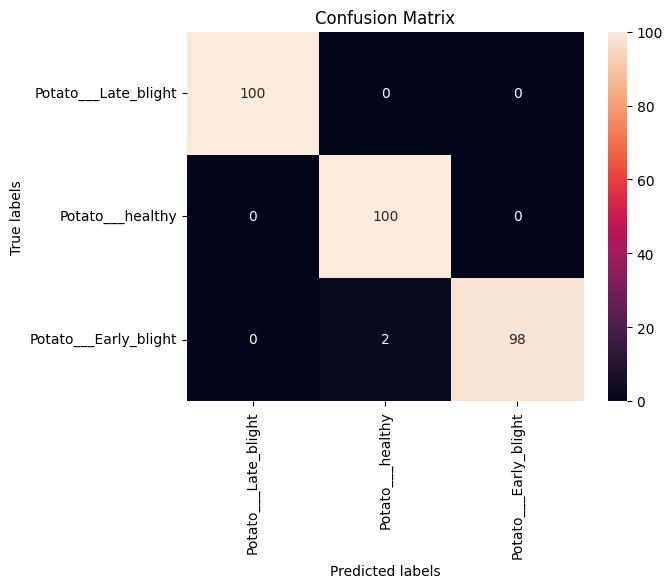

In [30]:
print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(test_labels_encoded, predictions))
print('Precision: \t\t', precision_score(test_labels_encoded, predictions, average='weighted'))
print('Recall: \t\t', recall_score(test_labels_encoded, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(test_labels_encoded, predictions, average='micro'), '\n')

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=test_labels_encoded, predictions=predictions).numpy()

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);

ax.set_title('Confusion Matrix');

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');

ax.xaxis.set_ticklabels(CLASSES);
ax.yaxis.set_ticklabels(CLASSES);

plt.xticks(rotation = 90)
plt.yticks(rotation = 360)

plt.show()

In [31]:
import joblib

joblib.dump(model, 'svm_model.h5')

['svm_model.h5']

In [32]:
from google.colab import files

files.download('svm_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>